Normally a pipeline would be executed in the following way

In [37]:
from transformers import pipeline

classifier = pipeline('sentiment-analysis')

classifier([
    "You are a good boy",
    "Happy Birthday",
    "The weather is good today",
    "you are a bad boy"
])

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9998822212219238},
 {'label': 'POSITIVE', 'score': 0.9998631477355957},
 {'label': 'POSITIVE', 'score': 0.9998564720153809},
 {'label': 'NEGATIVE', 'score': 0.9621484875679016}]

This is what happens under the hood

In [38]:
from transformers import AutoTokenizer

checkpoint = 'distilbert-base-uncased-finetuned-sst-2-english'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

raw_inputs = [
    "You are a good boy",
    "Happy Birthday",
    "The weather is good today",
    "you are a bad boy"
]

inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="tf")

# Padding and truncation is set to true since behind tokenizer the sentences are converted into fixed size tensors.
# The reason for not using ragged tensors is that deep learning models require a fixed size input.
# Even though storing Ragged Tensors would be memory efficient but it would require the whole deep learning model to change. (which is not practically possible)
# Truncation = True would reduce the sentence length if it exceeds the max size the model can handle


In [39]:
print(inputs)

{'input_ids': <tf.Tensor: shape=(4, 7), dtype=int32, numpy=
array([[ 101, 2017, 2024, 1037, 2204, 2879,  102],
       [ 101, 3407, 5798,  102,    0,    0,    0],
       [ 101, 1996, 4633, 2003, 2204, 2651,  102],
       [ 101, 2017, 2024, 1037, 2919, 2879,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(4, 7), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}


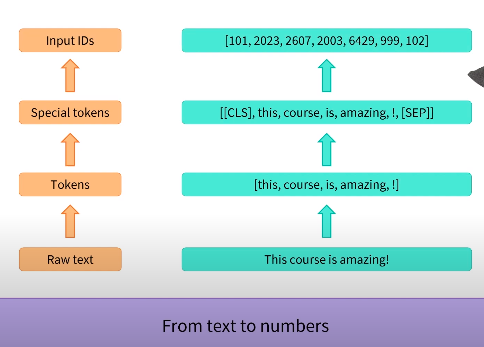

In [40]:
# tfautomodel api loads the whole model except for the head of the model
from transformers import TFAutoModel

checkpoint = 'distilbert-base-uncased-finetuned-sst-2-english'
model = TFAutoModel.from_pretrained(checkpoint)
output = model(inputs)

print(output.last_hidden_state.shape)
# the output is a high dimensional tensor which is not useful for our
# classification problem so we do the following

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


(4, 7, 768)


In [41]:
from transformers import TFAutoModelForSequenceClassification

checkpoint = 'distilbert-base-uncased-finetuned-sst-2-english'
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(inputs)

print(outputs.logits)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


tf.Tensor(
[[-4.32914    4.7177505]
 [-4.264352   4.6320724]
 [-4.238576   4.6107016]
 [ 1.7395172 -1.4959842]], shape=(4, 2), dtype=float32)


In [42]:
import tensorflow as tf

predictions = tf.math.softmax(outputs.logits, axis=1)
print(predictions)

tf.Tensor(
[[1.1774280e-04 9.9988222e-01]
 [1.3685875e-04 9.9986315e-01]
 [1.4346479e-04 9.9985647e-01]
 [9.6214861e-01 3.7851386e-02]], shape=(4, 2), dtype=float32)


In [60]:
print(model.config.id2label)
for i in range(len(predictions)):
  num = tf.math.argmax(predictions[i])
  # use tf.numpy to convert a tensorflow output to numpy output
  index = num.numpy()

  print(model.config.id2label[index])

{0: 'NEGATIVE', 1: 'POSITIVE'}
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
